<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/Logo_UTFSM.png/250px-Logo_UTFSM.png style="float:right;height:90px">
<img src=http://carla2014.ccarla.org/img/logo_DI_UTFSM.jpg style="float:left;height:90px">
<center>
    <h1> Scientific Programming in Python  </h1>
    <h2> Actividad 5 </h2> 
</center>

<center>    
    Roberto Felipe Fuentes Zenteno - `roberto.fuentes@alumnos.usm.cl`.
</center>

In [1]:
import numba
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

#librerias extra y que se deben instalar
from tabulate import tabulate
from IPython.display import HTML

%load_ext Cython

## La distancia de Hausdorff nuevamente...

En esta actividad volveremos a implementar la distancia/métrica de Hausdorff, pero ahora utilizando Cython.

__La métrica de Hausdorff__ corresponde a un métrica o distancia ocupada para medir cuán disímiles son dos subconjuntos dados. 

Esta tiene muchas aplicaciones, en particular para comparar el parecido entre imágenes. En el caso en donde los conjuntos son arreglos bidimensionales, la definición es la siguiente:

Sean $X \in \mathbb{R}^{m \times 3}$ e  $Y \in \mathbb{R}^{n \times 3}$ dos matrices, la métrica/distancia de Hausdorff sobre sobre estas como:

$$
d_H(X,Y) = \max \left(\ \max_{i\leq m} \min_{j \leq n} d(X[i],Y[j]), \ \max_{j\leq n} \min_{i \leq m} d(Y[j],X[i]) \ \right)
$$

donde $d$ es la _distancia Euclideana_ clásica. ($X[i]$ indíca la i-ésima fila de X).

__Ilustración unidimensional:__ Distancia entre funciones.
<img src='data/hausdorff.png' style="width: 600px;">

A continuación se le proveen 3 funciones que implementan tal métrica, usando __Numba__.

## Implementacion Numba

In [2]:
@numba.jit('float64 (float64[:], float64[:])')
def metric_numba(x, y):
    """
    standard Euclidean distance
    """
    ret = x-y
    ret *= ret
    return np.sqrt(ret.sum())


@numba.jit('float64 (float64[:], float64[:,:])', nopython=True)
def inf_dist_numba(x, Y):
    """
    inf distance between row x and array Y
    """
    m = Y.shape[0]
    inf = np.inf
    for i in range(m):
        dist = metric_numba(x, Y[i])
        if dist < inf:
            inf = dist
    return inf

@numba.jit('float64 (float64[:,:], float64[:,:])', nopython=True)
def hausdorff_numba(X, Y):
    """
    Hausdorff distance between arrays X and Y
    """
    m = X.shape[0]
    n = Y.shape[0]
    sup1 = -1.
    sup2 = -1.
    
    for i in range(m):
        inf1 = inf_dist_numba(X[i], Y)
        if inf1 > sup1:
            sup1 = inf1
    for i in range(n):
        inf2 = inf_dist_numba(Y[i], X)
        if inf2 > sup2:
            sup2 = inf2
            
    return max(sup1, sup2)

Se solicita que realice lo siguiente:

1. Escribir el equivalente __Cython__ de las tres funciones anteriores, ocupando todas las optimizaciones posibles: __Compiler directives__, __Memory Views__, __Inline Functions__, __Pure C functions__ o cualquier otra optimización que usted considere conveniente.
2. Cree `10` arreglos $X,Y$ aleatorios, con cantidad creciente de filas, y realice análsis de tiempos de ejecuciones de las versiones __Numba__ y __Cython__ de las funciontes anteriores sobre estos arreglos.
3. Concluya.

## Desarrollo

## Pregunta 1

### Implementacion en Cython

In [8]:
%%cython -a -c=-fPIC -c=-fwrapv -c=-O3 -c=-fno-strict-aliasing
#!python
#cython: cdivision=True, boundscheck=False, nonecheck=False, wraparound=False, initializedcheck=False

import numpy as np
cimport numpy as cnp

ctypedef cnp.float64_t float64_t
from libc.math cimport sqrt

cdef inline float64_t metric_cython(float64_t[::1] a, float64_t[::1] b):
    cdef:
        int i = 0
        int n = a.shape[0]
        float ret = 0
    for i in range(n):
        ret += (a[i]-b[i])**2
    return sqrt(ret)

cdef inline float64_t inf_dist_cython(float64_t[::1] x, float64_t[:,::1] Y):
    cdef:
        int m = Y.shape[0]
        float inf = np.inf
        int i = 0
        float dist = 0
    for i in range(m):
        dist = metric_cython(x, Y[i])
        for j in range(m):
            if dist < inf:
                inf = dist
    return inf

def hausdorff_cython(X,Y):
    cdef:
        int m = X.shape[0]
        int n = Y.shape[0]
        float sup1 = -1.
        float sup2 = -1.
        int i = 0
    for i in range(m):
        inf1 = inf_dist_cython(X[i], Y)
        if inf1 > sup1:
            sup1 = inf1
    for i in range(n):
        inf2 = inf_dist_cython(Y[i], X)
        if inf2 > sup2:
            sup2 = inf2
    if sup1 > sup2:
        return sup1
    return sup2

### Pregunta 2

#### Celda con las matrices que se usaran para el experimento:

In [9]:
#Experimento 1
X1 = np.random.random((100,3))
Y1 = np.random.random((50,3))

#Experimento 2
X2 = np.random.random((200,3))
Y2 = np.random.random((100,3))

#Experimento 3
X3 = np.random.random((300,3))
Y3 = np.random.random((150,3))

#Experimento 4
X4 = np.random.random((400,3))
Y4 = np.random.random((200,3))

#Experimento 5
X5 = np.random.random((500,3))
Y5 = np.random.random((250,3))

#Experimento 6
X6 = np.random.random((600,3))
Y6 = np.random.random((300,3))

#Experimento 7
X7 = np.random.random((700,3))
Y7 = np.random.random((350,3))

#Experimento 8
X8 = np.random.random((800,3))
Y8 = np.random.random((400,3))

#Experimento 9
X9 = np.random.random((900,3))
Y9 = np.random.random((450,3))

#Experimento 10
X10 = np.random.random((1000,3))
Y10 = np.random.random((500,3))

In [10]:
print("Experimento 1: \n")
naive1 = %timeit -o hausdorff_numba(X1,Y1)
jitted1 = %timeit -o hausdorff_cython(X1,Y1)
result1 = "{0} times faster \n".format(naive1.best/jitted1.best)

print("\n Experimento 2: \n")
naive2 = %timeit -o hausdorff_numba(X2,Y2)
jitted2 = %timeit -o hausdorff_cython(X2,Y2)
result2 = "{0} times faster \n".format(naive2.best/jitted2.best)

print("\n Experimento 3: \n")
naive3 = %timeit -o hausdorff_numba(X3,Y3)
jitted3 = %timeit -o hausdorff_cython(X3,Y3)
result3 = "{0} times faster \n".format(naive3.best/jitted3.best)

print("\n Experimento 4: \n")
naive4 = %timeit -o hausdorff_numba(X4,Y4)
jitted4 = %timeit -o hausdorff_cython(X4,Y4)
result4 = "{0} times faster \n".format(naive4.best/jitted4.best)

print("\n Experimento 5: \n")
naive5 = %timeit -o hausdorff_numba(X5,Y5)
jitted5 = %timeit -o hausdorff_cython(X5,Y5)
result5 = "{0} times faster \n".format(naive5.best/jitted5.best)

print("\n Experimento 6: \n")
naive6 = %timeit -o hausdorff_numba(X6,Y6)
jitted6 = %timeit -o hausdorff_cython(X6,Y6)
result6 = "{0} times faster \n".format(naive6.best/jitted6.best)

print("\n Experimento 7: \n")
naive7 = %timeit -o hausdorff_numba(X7,Y7)
jitted7 = %timeit -o hausdorff_cython(X7,Y7)
result7 = "{0} times faster \n".format(naive7.best/jitted7.best)

print("\n Experimento 8: \n")
naive8 = %timeit -o hausdorff_numba(X8,Y8)
jitted8 = %timeit -o hausdorff_cython(X8,Y8)
result8 = "{0} times faster \n".format(naive8.best/jitted8.best)

print("\n Experimento 9: \n")
naive9 = %timeit -o hausdorff_numba(X9,Y9)
jitted9 = %timeit -o hausdorff_cython(X9,Y9)
result9 = "{0} times faster \n".format(naive9.best/jitted9.best)

print("\n Experimento 10: \n")
naive10 = %timeit -o hausdorff_numba(X10,Y10)
jitted10 = %timeit -o hausdorff_cython(X10,Y10)
result10 = "{0} times faster \n".format(naive10.best/jitted10.best)

sub_experimento_1 = [naive1,jitted1,result1]
sub_experimento_2 = [naive2,jitted2,result2]
sub_experimento_3 = [naive3,jitted3,result3]
sub_experimento_4 = [naive4,jitted4,result4]
sub_experimento_5 = [naive5,jitted5,result5]
sub_experimento_6 = [naive6,jitted6,result6]
sub_experimento_7 = [naive7,jitted7,result7]
sub_experimento_8 = [naive8,jitted8,result8]
sub_experimento_9 = [naive9,jitted9,result9]
sub_experimento_10 = [naive10,jitted10,result10]

Experimento 1: 

2.4 ms ± 57.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
607 µs ± 44.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

 Experimento 2: 

9.36 ms ± 68.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.81 ms ± 15 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

 Experimento 3: 

21.3 ms ± 349 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.7 ms ± 77.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

 Experimento 4: 

38 ms ± 403 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
8.18 ms ± 57.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

 Experimento 5: 

58.2 ms ± 591 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
16 ms ± 712 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

 Experimento 6: 

83.5 ms ± 761 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
24.9 ms ± 374 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

 Experimento 7: 

115 ms ± 1.05 ms per lo

In [11]:
data = [[str(round(sub_experimento_1[0].best*1e3))+(" milliseconds"),str(round(sub_experimento_1[1].best*1e3))+(" milliseconds"),sub_experimento_1[2]],
        [str(round(sub_experimento_2[0].best*1e3))+(" milliseconds"),str(round(sub_experimento_2[1].best*1e3))+(" milliseconds"),sub_experimento_2[2]],
        [str(round(sub_experimento_3[0].best*1e3))+(" milliseconds"),str(round(sub_experimento_3[1].best*1e3))+(" milliseconds"),sub_experimento_3[2]],
        [str(round(sub_experimento_4[0].best*1e3))+(" milliseconds"),str(round(sub_experimento_4[1].best*1e3))+(" milliseconds"),sub_experimento_4[2]],
        [str(round(sub_experimento_5[0].best*1e3))+(" milliseconds"),str(round(sub_experimento_5[1].best*1e3))+(" milliseconds"),sub_experimento_5[2]],
        [str(round(sub_experimento_6[0].best*1e3))+(" milliseconds"),str(round(sub_experimento_6[1].best*1e3))+(" milliseconds"),sub_experimento_6[2]],
        [str(round(sub_experimento_7[0].best*1e3))+(" milliseconds"),str(round(sub_experimento_7[1].best*1e3))+(" milliseconds"),sub_experimento_7[2]],
        [str(round(sub_experimento_8[0].best*1e3))+(" milliseconds"),str(round(sub_experimento_8[1].best*1e3))+(" milliseconds"),sub_experimento_8[2]],
        [str(round(sub_experimento_9[0].best*1e3))+(" milliseconds"),str(round(sub_experimento_9[1].best*1e3))+(" milliseconds"),sub_experimento_9[2]],
        [str(round(sub_experimento_10[0].best*1e3))+(" milliseconds"),str(round(sub_experimento_10[1].best*1e3))+(" milliseconds"),sub_experimento_10[2]]]
HTML(tabulate(data, headers= ['mejor tiempo python', 'mejor tiempo numba', 'veces mas rapido entre python y numba '], floatfmt='.3e', tablefmt='html'))

mejor tiempo python,mejor tiempo numba,veces mas rapido entre python y numba
2 milliseconds,1 milliseconds,4.206167448372897 times faster
9 milliseconds,2 milliseconds,5.189573663416683 times faster
21 milliseconds,5 milliseconds,4.4977129748102165 times faster
37 milliseconds,8 milliseconds,4.616479742421126 times faster
57 milliseconds,15 milliseconds,3.7412711437608754 times faster
83 milliseconds,24 milliseconds,3.3836110501395553 times faster
114 milliseconds,38 milliseconds,2.999911224992374 times faster
149 milliseconds,52 milliseconds,2.881832091490451 times faster
190 milliseconds,77 milliseconds,2.477039989293316 times faster
233 milliseconds,107 milliseconds,2.176090151824908 times faster


Podemos observar claramente que a medida que aumenta el tamaño de las filas en cada experimento, ambos algoritmos van en crecimiento en sus tiempos, aunque claramente la función con _cython_ siempre le gana a _numba_ (es aproximadamente 3 veces mas rapido la función con _cython_ que con _numba_), tomando como supuesto que se comparan los mejores tiempos de cada algoritmo. Para apreciarlo mejor, haremos un gráfico del tamaño de filas vs los tiempos de cada algoritmo:

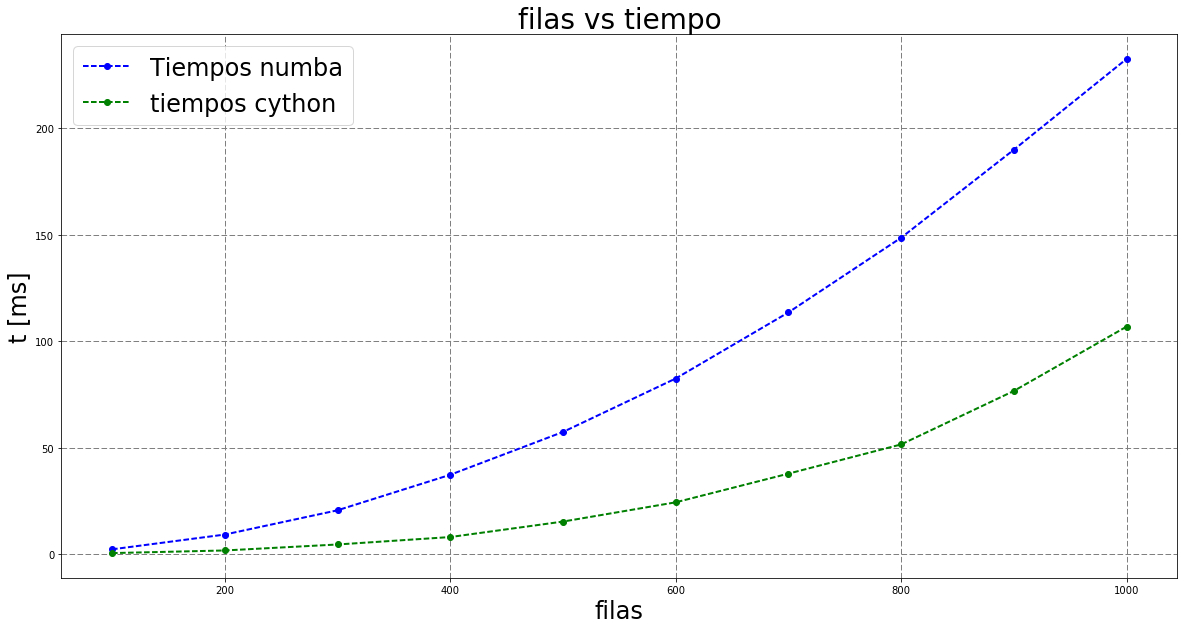

In [12]:
filas = list(range(100,1100,100))
exp_python = [sub_experimento_1[0].best*1e3,
              sub_experimento_2[0].best*1e3,
              sub_experimento_3[0].best*1e3,
              sub_experimento_4[0].best*1e3,
              sub_experimento_5[0].best*1e3,
              sub_experimento_6[0].best*1e3,
              sub_experimento_7[0].best*1e3,
              sub_experimento_8[0].best*1e3,
              sub_experimento_9[0].best*1e3,
              sub_experimento_10[0].best*1e3]

exp_numba = [sub_experimento_1[1].best*1e3,
              sub_experimento_2[1].best*1e3,
              sub_experimento_3[1].best*1e3,
              sub_experimento_4[1].best*1e3,
              sub_experimento_5[1].best*1e3,
              sub_experimento_6[1].best*1e3,
              sub_experimento_7[1].best*1e3,
              sub_experimento_8[1].best*1e3,
              sub_experimento_9[1].best*1e3,
              sub_experimento_10[1].best*1e3]

plt.figure(figsize=(20,10))
plt.plot(filas, exp_python, '--bo', linewidth = 2, label = 'Tiempos numba')
plt.plot(filas, exp_numba,'--go', linewidth = 2, label = 'tiempos cython')
plt.legend(loc = 2,prop={'size':24})
plt.xlabel("filas", fontsize = 24)
plt.ylabel("t [ms]", fontsize = 24)
plt.grid(True)
plt.grid(color = '0.5', linestyle = '--', linewidth = 1)
plt.axis('tight')
plt.title("filas vs tiempo",fontsize = 28, verticalalignment = 'baseline', horizontalalignment = 'center')
plt.show()

Observamos claramente que los tiempos en numba se disparan mas en comparación a los de cython, por lo que concluimos que la utilización de cython optimiza de forma considerable el tiempo de nuestro algoritmo.